In [36]:
import plotly.express as px
from tinyshift.series import trend_significance
from utilsforecast.preprocessing import fill_gaps
from utils import remove_leading_zeros, is_obsolete
from tinyshift.series import fourier_seasonality
from utilsforecast.losses import rmse, mae, bias, cfe, smape
from tinyshift.plot import stationarity_check, residual_check, corr_heatmap
import pandas as pd
from tinyshift.modelling import filter_features_by_vif
import numpy as np
from mlforecast import MLForecast
from mlforecast.lag_transforms import ExpandingMean, RollingMean, SeasonalRollingMean
from mlforecast.target_transforms import Differences
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from mlforecast.target_transforms import Differences
from lightgbm import LGBMRegressor
from utilsforecast.evaluation import evaluate
from stability import *

# Machine Learning (Linear Regression & Random Forest)

In [37]:
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
df = pd.read_csv(url, parse_dates=['Month'])
df["unique_id"] = "1"
df.rename(columns={"Month": "ds", "Passengers": "y"}, inplace=True)
df = fill_gaps(df, freq="ME", end="per_serie", id_col="unique_id", time_col="ds")
df = df.groupby("unique_id")[df.columns].apply(remove_leading_zeros).reset_index(drop=True)
df = fourier_seasonality(df, "ds", seasonality=["monthly"])
days_obsoletes=180
obsolete_series = df.groupby("unique_id")[df.columns].apply(is_obsolete, days_obsoletes)
obsolote_ids = obsolete_series[obsolete_series].index.tolist()
assert len(obsolote_ids) == 0, f"Obsolete series found: {obsolote_ids}"
df.groupby("unique_id")["y"].apply(trend_significance)

unique_id
1    (0.853638165603188, 4.020274506593391e-61)
Name: y, dtype: object

In [38]:
horizon = 12
train = df[:-horizon]
test = df[-horizon:]

In [39]:
def compute_lgbm_params(N: int):
    max_depth = int(np.ceil(np.log2(N) - 1))
    subsample_freq = 1
    colsample_bytree = 0.7
    n_estimators = 1000
    reg_lambda = 0.2
    reg_alpha = 0.2
    metric = "mae"
    learning_rate = 0.05
    min_child_samples = max(20, int(np.cbrt(N)))
    n_jobs = -1
    random_state = 42

    return {
        "max_depth": int(max_depth),
        "subsample_freq": subsample_freq,
        "colsample_bytree": colsample_bytree,
        "n_estimators": n_estimators,
        "metric": metric,
        "learning_rate": learning_rate,
        "num_leaves": 40,
        "min_child_samples": min_child_samples,
        "reg_alpha": reg_alpha,
        "reg_lambda": reg_lambda,
        "objective": "regression_l2",
        "n_jobs": n_jobs,
        "random_state": random_state
    }

In [40]:
config = compute_lgbm_params(len(train))
models = [LinearRegression(), RandomForestRegressor(random_state=42, n_jobs=-1, max_depth=int(np.ceil(np.log2(len(train)) - 1))), LGBMRegressor(**config, verbosity=-1)]

mf = MLForecast(
    models=models,
    freq='MS',
    lags=[2], #removi lag 1 e lag 12
    lag_transforms={
        1: [
        RollingMean(window_size=12), # Nível de longo prazo (12 meses)]},
        SeasonalRollingMean(window_size=2, season_length=12)
        ],
        6: [ExpandingMean()], # Média acumulada (longo prazo)
    },
    target_transforms=[Differences([1, 12])],
    date_features=["quarter"],
)

mf.fit(train, static_features=[])

MLForecast(models=[LinearRegression, RandomForestRegressor, LGBMRegressor], freq=MS, lag_features=['lag2', 'rolling_mean_lag1_window_size12', 'seasonal_rolling_mean_lag1_season_length12_window_size2', 'expanding_mean_lag6'], date_features=['quarter'], num_threads=1)

In [41]:
def wape(df, models, id_col='unique_id', target_col='y'):
    """
    Calcula o WAPE (Weighted Absolute Percentage Error).
    'df' é o DataFrame de avaliação com 'unique_id', 'ds', 'y' (target) e colunas de modelo.
    """
    actual = df[target_col].to_numpy()

    results = {}
    for model_name in models:
        forecast = df[model_name].to_numpy()

        numerator = np.sum(np.abs(forecast - actual))
        denominator = np.sum(np.abs(actual))

        if denominator == 0:
            wape_score = 0.0 
        else:
            wape_score = numerator / denominator

        results[model_name] = wape_score

    return pd.DataFrame({
        'unique_id': df[id_col].unique(),
        'metric': 'wape',
        **results
    })

In [42]:
metrics = [
    mae,
    rmse,
    bias,
    cfe,
    wape,
    smape
]

In [43]:
res = mf.predict(h=12, X_df=test[["unique_id", "ds", "monthly_sin", "monthly_cos"]])

In [44]:
res["y"] = test["y"].values

In [45]:
evaluate(res, 
         metrics=metrics, 
         models=["LinearRegression", "RandomForestRegressor", "LGBMRegressor"], 
         id_col="unique_id", 
         time_col="ds", 
         target_col="y")

,unique_id,metric,LinearRegression,RandomForestRegressor,LGBMRegressor
0,1,mae,13.113663,11.526782,13.377513
1,1,rmse,17.662115,16.089253,17.973882
2,1,bias,10.205571,4.595233,-0.960322
3,1,cfe,122.466858,55.142792,-11.523865
4,1,wape,0.027540,0.024207,0.028094
5,1,smape,0.014283,0.012574,0.014381


In [46]:
def standardize_coefficients(model: LinearRegression, df_train: pd.DataFrame, target="y"):
    """
    Standardize the coefficients of the model based on the standard deviation of the features and target.
    """
    std_coef = np.zeros(len(model.coef_))
    for i in range(len(model.feature_names_in_)):
        std_coef[i] = model.coef_[i] * df_train[model.feature_names_in_[i]].std() / df_train[target].std()
    return std_coef

In [47]:
feature_importance = pd.DataFrame({
    'feature': mf.models_["LinearRegression"].feature_names_in_,
    'std_coef': standardize_coefficients(mf.models_["LinearRegression"], mf.preprocess(train, static_features=[]))
}).sort_values(by='std_coef', ascending=False).reset_index(drop=True)

In [48]:
feature_importance

,feature,std_coef
0,monthly_sin,0.264737
1,lag2,0.131293
2,quarter,0.116840
3,expanding_mean_lag6,-0.026574
4,seasonal_rolling_mean_lag1_season_length12_win...,-0.155287
5,monthly_cos,-0.203433
6,rolling_mean_lag1_window_size12,-0.207809


In [49]:
feature_importance = pd.DataFrame({
    'feature': mf.models_["RandomForestRegressor"].feature_names_in_,
    'importance': mf.models_["RandomForestRegressor"].feature_importances_
}).sort_values(by='importance', ascending=False).reset_index(drop=True)

In [50]:
feature_importance

,feature,importance
0,expanding_mean_lag6,0.226073
1,rolling_mean_lag1_window_size12,0.216331
2,seasonal_rolling_mean_lag1_season_length12_win...,0.189187
3,lag2,0.147481
4,monthly_cos,0.104185
5,monthly_sin,0.102690
6,quarter,0.014053


In [51]:
feature_importance = pd.DataFrame({
    'feature': mf.models_["LGBMRegressor"].feature_names_in_,
    'importance': mf.models_["LGBMRegressor"].feature_importances_
}).sort_values(by='importance', ascending=False).reset_index(drop=True)

In [52]:
feature_importance

,feature,importance
0,seasonal_rolling_mean_lag1_season_length12_win...,720
1,lag2,643
2,rolling_mean_lag1_window_size12,570
3,expanding_mean_lag6,564
4,monthly_cos,361
5,monthly_sin,249
6,quarter,35


In [53]:
res

,unique_id,ds,LinearRegression,RandomForestRegressor,LGBMRegressor,y
0,1,1960-01-01,418.894958,423.043213,417.535645,417
1,1,1960-02-01,399.074585,403.817047,402.783264,391
2,1,1960-03-01,461.585815,464.519653,464.702850,419
3,1,1960-04-01,453.428040,450.481232,446.889221,461
4,1,1960-05-01,480.693298,474.062317,464.999634,472
5,1,1960-06-01,534.440613,530.902222,521.014465,535
6,1,1960-07-01,612.682800,604.392334,598.423035,622
7,1,1960-08-01,619.819214,612.346069,604.922485,606
8,1,1960-09-01,521.487366,509.074219,503.149414,508
9,1,1960-10-01,462.022522,451.634918,439.574738,461


In [54]:
res["residual_LR"] = res["y"] - res["LinearRegression"]
res["residual_RF"] = res["y"] - res["RandomForestRegressor"]
res["residual_LGBM"] = res["y"] - res["LGBMRegressor"]

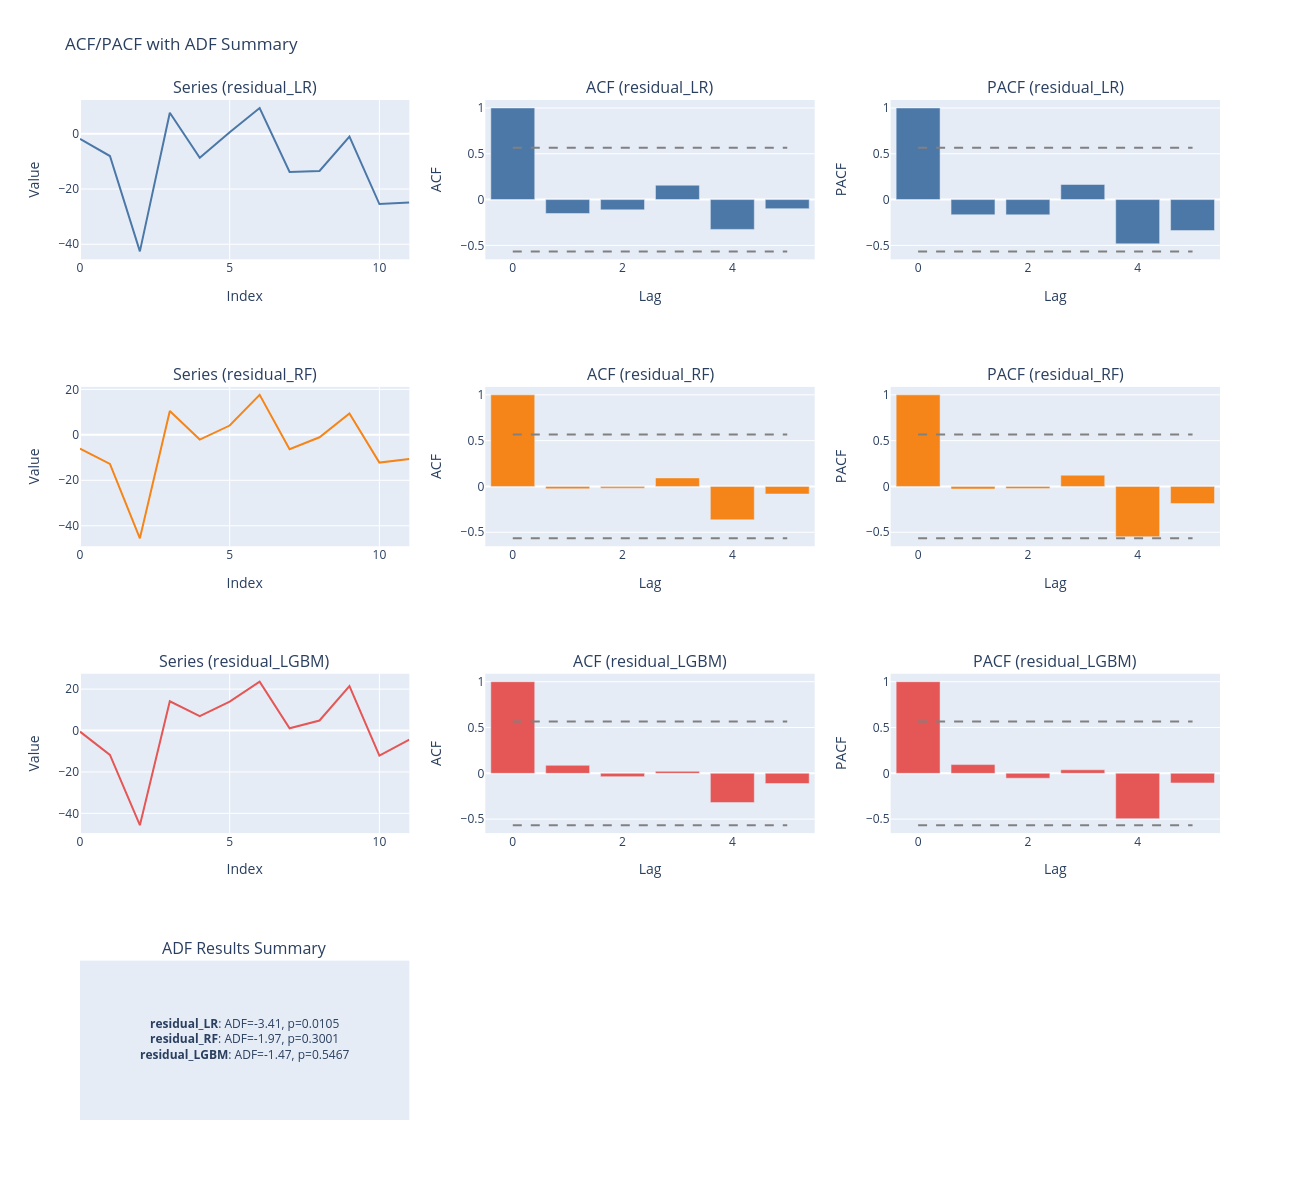

In [55]:
stationarity_check(res[["residual_LR", "residual_RF", "residual_LGBM"]], nlags=30, fig_type="png")

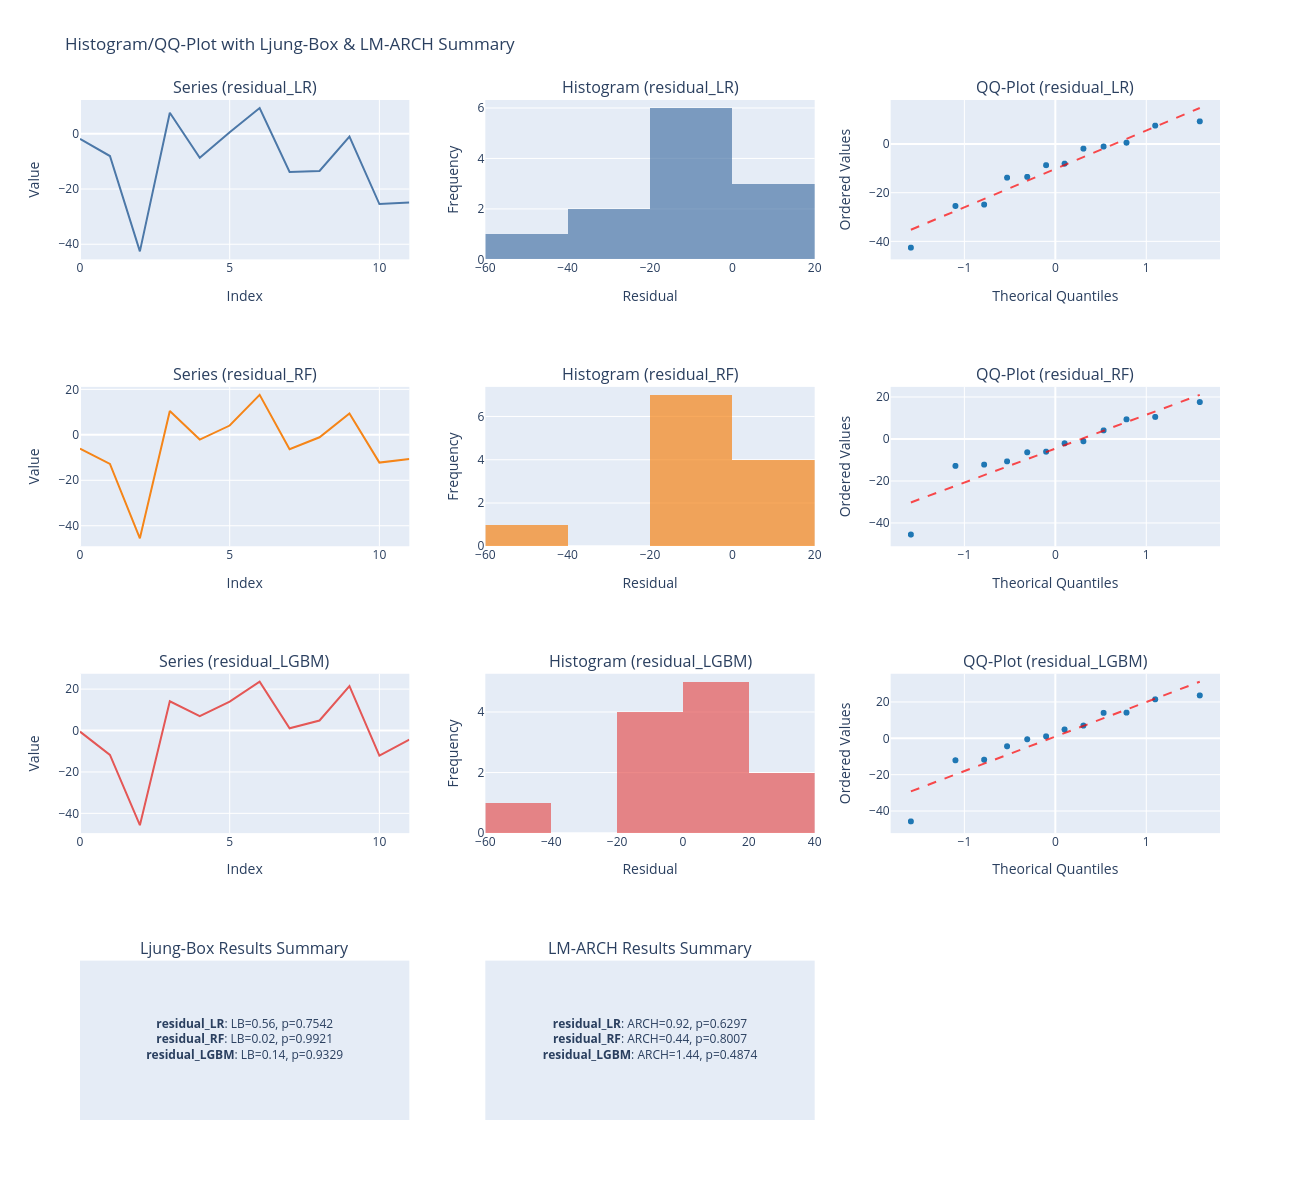

In [56]:
residual_check(res[["residual_LR", "residual_RF", "residual_LGBM"]], nlags=12, fig_type="png")

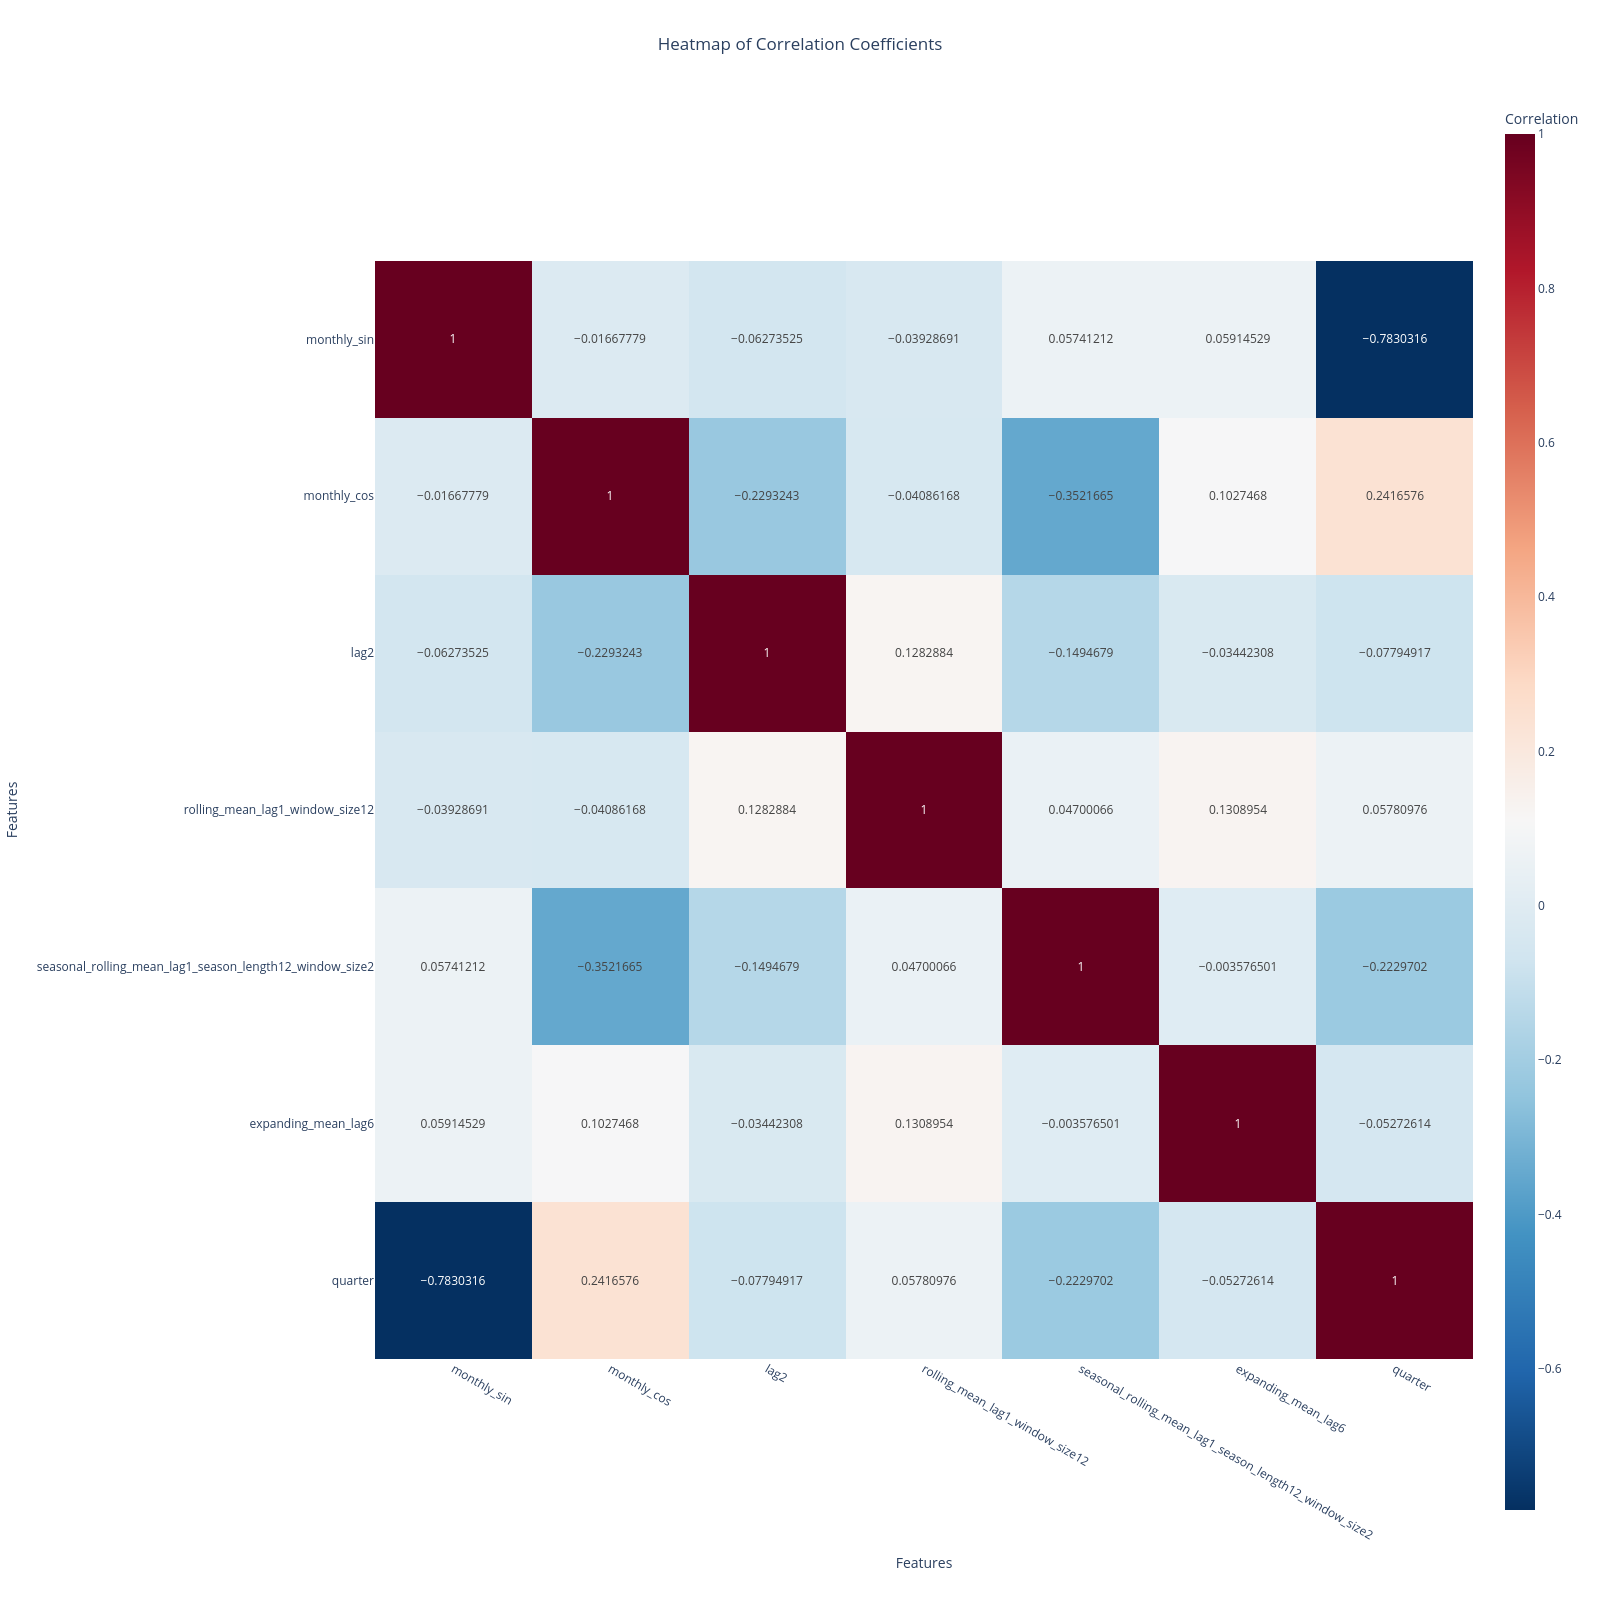

In [57]:
corr_heatmap(mf.preprocess(train, static_features=[]).drop(columns=["unique_id", "ds", "y"]), fig_type="png")

In [58]:
filter_features_by_vif(
    mf.preprocess(train, static_features=[]).drop(columns=["unique_id", "ds", "y"]),
    threshold=5.0,
    verbose=True,
)

array([ True,  True,  True,  True,  True,  True,  True])

In [59]:
fourier_seasonality


<function tinyshift.series.stats.fourier_seasonality(df: pandas.core.frame.DataFrame, time_col: str, seasonality: List[str])>

In [70]:
def adicionar_linhas_datetime_por_frequencia(df_original, freq, N):
    """
    Adiciona N linhas a cada unique_id no DataFrame, gerando novas datas 
    com base em uma frequência (freq) a partir da data original (ds).

    Args:
        df_original (pd.DataFrame): DataFrame original com colunas 'unique_id' e 'ds'.
        freq (str): Frequência de tempo do Pandas (ex: 'D' para diário, 'W' para semanal, 
                    'M' para mensal, 'H' para horário).
        N (int): Número de novas linhas a serem geradas para cada unique_id.

    Returns:
        pd.DataFrame: Novo DataFrame com as linhas adicionadas.
    """
    
    # Garantir que 'ds' seja do tipo datetime
    df_original['ds'] = pd.to_datetime(df_original['ds'])
    
    # Lista para armazenar os DataFrames gerados
    df_list = [df_original.copy()]

    # Agrupa por 'unique_id'
    grouped = df_original.groupby('unique_id')

    # Itera sobre cada grupo (unique_id)
    for unique_id, group in grouped:
        # A data inicial será a data máxima para aquele unique_id no DF original
        data_inicial = group['ds'].max() 

        # Gera o range de datas
        # O periods é N+1, mas a função date_range inclui a data inicial,
        # então usamos [1:] para pegar apenas as N datas seguintes
        novas_datas = pd.date_range(
            start=data_inicial, 
            periods=N + 1, 
            freq=freq
        )[1:] 

        # Cria um novo DataFrame para as novas linhas
        df_novas_linhas = pd.DataFrame({
            'unique_id': unique_id,
            'ds': novas_datas
        })
        
        # Opcional: Adicionar colunas adicionais com valor NaN ou outro valor padrão
        # for col in df_original.columns:
        #     if col not in ['unique_id', 'ds']:
        #         df_novas_linhas[col] = pd.NA # Ou outro valor, como None/0/etc.

        df_list.append(df_novas_linhas)

    # Concatena o DF original com todos os novos DataFrames
    df_final = pd.concat(df_list, ignore_index=True)
    
    # Remove as duplicatas caso a data_inicial fosse a última do DF original,
    # embora o [1:] evite isso, é uma boa prática garantir datas únicas por ID
    df_final.drop_duplicates(subset=['unique_id', 'ds'], inplace=True)
    
    # Opcional: Ordenar para melhor visualização
    df_final.sort_values(by=['unique_id', 'ds'], inplace=True)
    df_final.reset_index(drop=True, inplace=True)
    
    return df_final

In [75]:
test = adicionar_linhas_datetime_por_frequencia(test[["unique_id", "ds"]], "MS", 12)

/tmp/ipykernel_100362/1236182632.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [78]:
test = fourier_seasonality(test, "ds", seasonality=["monthly"])

In [79]:
res = mf.predict(h=24, X_df=test[["unique_id", "ds", "monthly_sin", "monthly_cos"]])

In [81]:
res

,unique_id,ds,LinearRegression,RandomForestRegressor,LGBMRegressor
0,1,1960-01-01,418.894958,423.043213,417.535645
1,1,1960-02-01,399.074585,403.817047,402.783264
2,1,1960-03-01,461.585815,464.519653,464.702850
3,1,1960-04-01,453.428040,450.481232,446.889221
4,1,1960-05-01,480.693298,474.062317,464.999634
5,1,1960-06-01,534.440613,530.902222,521.014465
6,1,1960-07-01,612.682800,604.392334,598.423035
7,1,1960-08-01,619.819214,612.346069,604.922485
8,1,1960-09-01,521.487366,509.074219,503.149414
9,1,1960-10-01,462.022522,451.634918,439.574738


In [84]:
seasonality_val = 12

masc_v_result = mascv(train["y"], res["LGBMRegressor"][12:], res["LGBMRegressor"][:12], seasonality_val)
rmssc_v_result = rmsscv(train["y"], res["LGBMRegressor"][12:], res["LGBMRegressor"][:12], seasonality_val)
macv_result = macv(res["LGBMRegressor"][12:], res["LGBMRegressor"][:12])
mach_result = mach(res["LGBMRegressor"][12:])
masc_h_result = masch(train["y"], res["LGBMRegressor"][12:], seasonality_val)
rmssc_h_result = rmssch(train["y"], res["LGBMRegressor"][12:], seasonality_val)
print(f"MAC(V) (Vertical Stability): {macv_result:.6f}")
print(f"MASC(V) (Vertical Stability - Absolute): {masc_v_result:.6f}")
print(f"RMSSC(V) (Vertical Stability - Squared): {rmssc_v_result:.6f}")
print(f"MAC(H) (Horizontal Stability): {mach_result:.6f}")
print(f"MASC(H) (Horizontal Stability - Absolute): {masc_h_result:.6f}")
print(f"RMSSC(H) (Horizontal Stability - Squared): {rmssc_h_result:.6f}")

MAC(V) (Vertical Stability): 67.517708
MASC(V) (Vertical Stability - Absolute): 2.251954
RMSSC(V) (Vertical Stability - Squared): 2.597050
MAC(H) (Horizontal Stability): 44.783276
MASC(H) (Horizontal Stability - Absolute): 1.470715
RMSSC(H) (Horizontal Stability - Squared): 1.562161
